In [ ]:
# install required system dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet==v1.5.0

In [ ]:
import math
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2
from collections import deque

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Open AI related
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML

# set up OpenAi Gym render in Colab
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
_display = Display(visible=False,  # use False with Xvfb
                   size=(1400, 900))
_ = _display.start()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parameters

In [ ]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 1 # explore rate (start)
EPS_END = 0.1 # explore rate (end)
MAX_EPS_DECAY_STEPS = 1000000
TARGET_UPDATE = 10 # Freqency of updating target network, copying all weights and biases in DQN
REPLAY_MEMORY_SIZE = 1000000
NUM_EPISODE = 12000
k = 4 # Agenet select new action on every kth frame
SCREEN_SIZE = 84 # height and width since we want training image to be a square

## Show Gym Environment

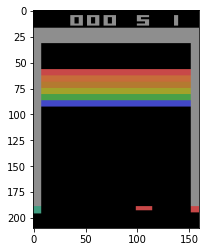

In [ ]:
env = gym.make('Breakout-v0').unwrapped
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # returned screen by gym is 400x600x3

In [ ]:
print("number of actions: ", env.action_space.n)
print("actions available: ", env.get_action_meanings())

number of actions:  4
actions available:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [ ]:
class WrapAtariEnv(gym.Wrapper):
    def __init__(self, env, frames_skipped=k, test = False):
        gym.Wrapper.__init__(self, env)
        self.no_op_max = 30
        self.frames_skipped = frames_skipped

        self.observation_space = gym.spaces.Box(low=0, high=255,
                                                shape=(84, 84),
                                                dtype=np.float32)
        self.lives = 0
        self.game_ended = True
        self.test = test

    def reset(self):
        if not self.test:
            # only reset on end of episode
            if self.game_ended:
                self.env.reset()
                noops = np.random.randint(1, self.no_op_max + 1)
                # execute the action no-op
                for i in range(noops):
                    ob, reward, done, info = self.env.step(0)
                    if done:
                        ob = self.reset()
            else:
                # execute no-op to advance from lost life state
                ob, reward, done, info = self.env.step(0) 
        else:
            self.env.reset()
            noops = np.random.randint(1, self.no_op_max + 1)
            # execute the action no-op
            for i in range(noops):
                ob, reward, done, info = self.env.step(0)  
                if done:
                    ob = self.reset()
        
        # process observation
        return self.process_ob(ob)

    def step(self, action):
        total_reward = 0.
        for i in range(self.frames_skipped):
            ob, reward, done, info = self.env.step(action)
            total_reward += reward
        if not self.test:
            self.game_ended = done
            lives_left = self.env.unwrapped.ale.lives()  # how many lives left
            if lives_left < self.lives and lives_left > 0: # if agent lost a life
                done = True
            self.lives = lives_left
        ob = self.process_ob(ob)
        return ob, total_reward, done, info

    def process_ob(self, ob):
        # convert RGB image to Graysacle image and resize
        im = cv2.cvtColor(ob, cv2.COLOR_RGB2GRAY)
        ob = cv2.resize(im, (84, 84), interpolation=cv2.INTER_AREA)
        # Convert to float, rescale, convert to torch tensor
        ob = np.ascontiguousarray(ob, dtype=np.float32) / 255
        ob = torch.from_numpy(ob)
        return ob

In [ ]:
env = WrapAtariEnv(env)
env.reset()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Replay Memory

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q Network

In [ ]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        conv_size1 = conv2d_size_out(SCREEN_SIZE, 8, 4)
        conv_size2 = conv2d_size_out(conv_size1, 4, 2)
        conv_size3 = conv2d_size_out(conv_size2, 3, 1)

        linear_input_size = conv_size3 * conv_size3 * 64
        print("linear_input_size:", linear_input_size)

        # fully connected layor
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        # fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [ ]:
# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

steps_done = 0

linear_input_size: 3136
linear_input_size: 3136


In [ ]:
def decay_epsilon(step):
    # linearly decay epsilon
    frac = min(float(step) / MAX_EPS_DECAY_STEPS, 1.0)
    return EPS_START + frac*(EPS_END - EPS_START)

def get_q_values(state):
    return policy_net(state)

def select_action(q_values):
    global steps_done
    sample = random.random()
    eps_threshold = decay_epsilon(steps_done)
    steps_done += 1
    if sample > eps_threshold:
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return q_values.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    next_state_values[non_final_mask] = next_state_values[non_final_mask].type(torch.float32)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    expected_state_action_values = expected_state_action_values.type(torch.float32)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = loss.type(torch.float32)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def stack_past_four_frames(frame1, frame2, frame3, frame4):
    frames = torch.stack([frame1, frame2, frame3, frame4], dim=0)
    # Add a batch dimension (BCHW)
    return frames.unsqueeze(0).to(device)

In [ ]:
episode_durations = []
all_episode_max_q_vals = []
all_episode_training_time = []
all_episode_scores = []

def train(num_episode, environment):
    for i_episode in range(num_episode):
        max_q_vals = []
        total_score = 0

        # Initialize the environment and state
        environment.reset()
        environment.step(1) # fire the ball
        # Stack 4 most recent frames
        past_ob3, _, _, _ = environment.step(0) # 0 -> no op
        past_ob2, _, _, _ = environment.step(0)
        past_ob1, _, _, _ = environment.step(0)
        current_ob, _, _, _ = environment.step(0)
        state = stack_past_four_frames(current_ob, past_ob1, past_ob2, past_ob3)

        start = time.time()
        for t in count():
            print("episode {}, iteration {}".format(i_episode, t))

            environment.render()     
            # Compute Q values from policy net
            q_values = get_q_values(state)
            print("q values: ", q_values)
            max_q_vals.append(q_values.max().item())

            # Choose action based on max q value
            action = select_action(q_values)
            print("Action: ", action.item())

            # Execute action
            new_ob, reward, done, info = environment.step(action.item())
            total_score += reward
            # convert reward to {+1, -1, 0}
            reward = np.sign(reward)  
            reward = torch.tensor([reward], device=device)
            
            print("reward: ", reward)
            print("current total score: ", total_score)

            # Observe new state
            past_ob3 = past_ob2
            past_ob2 = past_ob1
            past_ob1 = current_ob
            current_ob = new_ob
            
            if not done:
                next_state = stack_past_four_frames(current_ob, past_ob1, past_ob2, past_ob3)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model()
            if done:
                end = time.time()
                all_episode_training_time.append(end - start)
                episode_durations.append(t + 1)
                all_episode_max_q_vals.append(max_q_vals)
                all_episode_scores.append(total_score)
                break
        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Training Complete')

In [ ]:
train(NUM_EPISODE, env)
env.close()

Streaming output truncated to the last 5000 lines.
episode 9780, iteration 3
q values:  tensor([[0.4081, 0.3942, 0.4004, 0.3972]], grad_fn=<AddmmBackward>)
Action:  1
reward:  tensor([0.], dtype=torch.float64)
current total score:  0.0
episode 9781, iteration 0
q values:  tensor([[0.4010, 0.3829, 0.3901, 0.3975]], grad_fn=<AddmmBackward>)
Action:  3
reward:  tensor([0.], dtype=torch.float64)
current total score:  0.0
episode 9781, iteration 1
q values:  tensor([[0.4100, 0.3729, 0.3970, 0.3976]], grad_fn=<AddmmBackward>)
Action:  0
reward:  tensor([0.], dtype=torch.float64)
current total score:  0.0
episode 9781, iteration 2
q values:  tensor([[0.4239, 0.3772, 0.3871, 0.3978]], grad_fn=<AddmmBackward>)
Action:  1
reward:  tensor([0.], dtype=torch.float64)
current total score:  0.0
episode 9782, iteration 0
q values:  tensor([[0.4154, 0.3905, 0.3909, 0.3921]], grad_fn=<AddmmBackward>)
Action:  1
reward:  tensor([0.], dtype=torch.float64)
current total score:  0.0
episode 9782, iteration 

In [ ]:
filtered_durations = []
for i in range(len(episode_durations)):
  if i % 100 == 0:
    filtered_durations.append(episode_durations[i])

plt.title('Iterations per Episode')
plt.xlabel('Episode')
plt.ylabel('Iterations (per 100)')
plt.plot(filtered_durations)

In [ ]:
filtered_runtime = []
for i in range(len(all_episode_training_time)):
  if i % 100 == 0:
    filtered_runtime.append(all_episode_training_time[i])

plt.title('Runtime(s) per Episode')
plt.xlabel('Episode (per 100)')
plt.ylabel('Runtime(s)')
plt.plot(filtered_runtime)

In [ ]:
filtered_scores = []
for i in range(len(all_episode_scores)):
  if i % 100 == 0:
    filtered_scores.append(all_episode_scores[i])
plt.title('Score per Episode')
plt.xlabel('Episode (per 100)')
plt.ylabel('Score')
plt.plot(filtered_scores)

In [ ]:
# calculate average max q value per episode
avg_max_qVals = []
for vals in all_episode_max_q_vals:
    avg_max_qVal = sum(vals)/len(vals)
    avg_max_qVals.append(avg_max_qVal)

filtered_max_q_value = []
for i in range(len(avg_max_qVals)):
  if i % 100 == 0:
    filtered_max_q_value.append(avg_max_qVals[i])
plt.title('Average Max Q value per Episode')
plt.xlabel('Episode (per 100)')
plt.ylabel('Average Max Q value')
plt.plot(filtered_max_q_value)

## Record

In [ ]:
video_save_interval = 1
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
      mp4 = mp4list[0]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))
    else: 
      print("Could not find video")

def wrap_env(envi):
    envi = Monitor(envi, './video', video_callable=lambda episode_id: episode_id % video_save_interval == 0, force=True)
    return envi

In [ ]:
# Initialize the environment and state
record_env = gym.make('Breakout-v0').unwrapped
record_env = WrapAtariEnv(record_env)
record_env = wrap_env(record_env)
record_env.reset()
train(1, record_env)
print("Score: ", all_episode_scores[-1])

In [ ]:
record_env.close()
show_video()

In [ ]:
avg_max_qVal = sum(all_episode_max_q_vals[-1])/len(all_episode_max_q_vals[-1])
avg_max_qVal

## Test

In [ ]:
video_save_interval = 1
# Initialize the environment and state
total_score = 0
test_env = gym.make('Breakout-v0').unwrapped
test_env = WrapAtariEnv(test_env, test = True)
test_env = wrap_env(test_env)
test_env.reset()

# Stack 4 most recent frames
past_ob3, _, _, _= test_env.step(0) # 0 -> no op
past_ob2, _, _, _= test_env.step(0)
past_ob1, _, _, _ = test_env.step(0)
current_ob, _, _, _ = test_env.step(0)
state = stack_past_four_frames(current_ob, past_ob1, past_ob2, past_ob3)

real_done = False

start = time.time()
for t in count():
    print("iteration {}".format(t))

    test_env.render()     
    # Compute Q values from policy net
    q_values = get_q_values(state)
    print("q values: ", q_values)

    # Choose action based on max q value
    action = select_action(q_values)
    print("Action: ", action.item())

    # Execute action
    new_ob, reward, done, info = test_env.step(action.item())
    total_score += reward
    print("current total score: ", total_score)

    # Observe new state
    past_ob3 = past_ob2
    past_ob2 = past_ob1
    past_ob1 = current_ob
    current_ob = new_ob
    
    # check if game ended
    lives_left = test_env.env.unwrapped.ale.lives()  # how many lives left
    if lives_left <= 0:
       real_done = True
    
    if not real_done:
        next_state = stack_past_four_frames(current_ob, past_ob1, past_ob2, past_ob3)
    else:
        next_state = None

    # Move to the next state
    state = next_state

    if real_done or t > 1000:
        end = time.time()
        print("Total testing runtime in seconds: ", end - start)
        break
print('Testing Complete, total score: ', total_score)

In [ ]:
test_env.close()
show_video()